# K Nearest Neighbor

## Using train - test comparison
If we take the input of the test data and pair it to the nearest train data using a simple nearest neighbor approach, we can see if the train_data target value is the same as the target value of the test set

### Importing data splits 
It's important to get the exact same data split as used in a model, therefore we must load the data splits objects that the model has logged.

In [84]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"

n = 500
k = 12
run = 2
nn_run_dir = f"../nn_runs/torch_mlp_n{n}_k{k}_run{run}/"

# Read data splits .npz file
data_splits = np.load(nn_run_dir + f"torchMLP_splits_run{run}.npz")
X_train = data_splits['X_train']
y_train = data_splits['y_train']
X_val = data_splits['X_val']
y_val = data_splits['y_val']
X_test = data_splits['X_test']
y_test = data_splits['y_test']

### Setting up the KNN
https://www.geeksforgeeks.org/machine-learning/k-nearest-neighbours/
The idea is that if we take all the train data, we can categorize it by its target value (binary hostrange 0 or 1). Then, we can iteratively assign rows from test data by a distance measurement (e.g. euclidean distance), and check if the assignment is correct from the target value of the test data. Confusion matrix can be constructed from this if we capture the instances and results of applying test data

In [85]:
class KNNClassifier:
    def __init__(self, train_data, train_label, k=3, distance_metric='euclidean', silent=True):
        self.k = k
        self.train_data = train_data
        self.train_label = train_label
        self.distance_metric = distance_metric

        self.distance_dict = {
            'euclidean': self._euclidean_distance,
            'manhattan': self._manhattan_distance,
            'minkowski': self._minkowski_distance,
            'chebyshev': self._chebyshev_distance
        }

        self.silent = silent

    def predict(self, test_input):
        """
        Predict the label for a single test input. Uses a distance function to find the k nearest neighbors.
        Then, returns the most common label among those neighbors using Counter & most_common.
        """
        distances = []
        for i in range(len(self.train_data)):
            dist = self.distance_dict[self.distance_metric](test_input, self.train_data[i])
            distances.append((dist, self.train_label[i]))
        distances.sort(key=lambda x: x[0])
        k_nearest_labels = [label for _, label in distances[:self.k]]
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def evaluate(self, test_data, test_labels):
        if len(test_data) != len(test_labels):
            raise ValueError("Test data and labels must have the same length.")
        
        correct = 0
        if not self.silent:
            print("Evaluating KNN Classifier...")
            for i in tqdm(range(len(test_data)), desc="Evaluating KNN using test data", unit="sample"):
                pred_label = self.predict(test_data[i])
                if pred_label == test_labels[i]:
                    correct += 1
            accuracy = correct / len(test_data)
            return accuracy
        else:
            for i in range(len(test_data)):
                pred_label = self.predict(test_data[i])
                if pred_label == test_labels[i]:
                    correct += 1
            accuracy = correct / len(test_data)
            return accuracy

    ### Distance functions ----------------------------------------------
    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))
    
    def _manhattan_distance(self, point1, point2):
        return np.sum(np.abs(np.array(point1) - np.array(point2)))
    
    def _minkowski_distance(self, point1, point2, p=3):
        return np.sum(np.abs(np.array(point1) - np.array(point2))**p)**(1/p)
    
    def _chebyshev_distance(self, point1, point2):
        return np.max(np.abs(np.array(point1) - np.array(point2)))

### Running KNN - 1 Input

In [86]:
# Working example
# Return a random integer from 0 to range(len(X_test))
idx = np.random.randint(0, len(X_test))
print("Randomly chose index: ", idx)
print(X_test[idx])
print(y_test[idx])

Randomly chose index:  453
[-0.67588003 -1.10568874 -1.08531346 ...  0.          0.
  0.        ]
0


In [87]:
KNNclass = KNNClassifier(X_train, y_train, k=6)
pred_label = KNNclass.predict(X_test[0])  # Example prediction
if pred_label == y_test[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")

Correct prediction


##### Running until Incorrect Prediction

In [88]:
predict = True
counter = 0
while predict:
    idx = np.random.randint(0, len(X_test))
    print("Randomly chose index: ", idx)
    print("Test data: ", X_test[idx])
    print("True label: ", y_test[idx])
    pred_label = KNNclass.predict(X_test[idx])
    print("Predicted label: ", pred_label)
    if pred_label == y_test[idx]:
        print("Correct prediction")
        counter += 1
    else:
        print("Incorrect prediction")
        predict = False
print(f"Total correct predictions before incorrect: {counter}")

Randomly chose index:  3
Test data:  [-0.67588003 -1.10568874 -1.08531346 ...  0.          0.
  0.        ]
True label:  0
Predicted label:  0
Correct prediction
Randomly chose index:  209
Test data:  [-0.67588003  0.90441366  0.92139279 ...  0.          0.
  0.        ]
True label:  0
Predicted label:  0
Correct prediction
Randomly chose index:  228
Test data:  [1.47955251 0.90441366 0.92139279 ... 0.         0.         0.        ]
True label:  0
Predicted label:  0
Correct prediction
Randomly chose index:  344
Test data:  [1.47955251 0.90441366 0.92139279 ... 0.         0.         0.        ]
True label:  1
Predicted label:  0
Incorrect prediction
Total correct predictions before incorrect: 3


### Running KNN - all test 

In [89]:
KNNclass = KNNClassifier(X_train, y_train, k=2, 
                         silent=False, 
                         distance_metric='manhattan'
                         )

accuracy = KNNclass.evaluate(X_test, y_test)
print(f"KNN Classifier Accuracy on Test Set: {accuracy*100:.2f}%")

Evaluating KNN Classifier...


Evaluating KNN using test data: 100%|██████████| 506/506 [00:41<00:00, 12.18sample/s]

KNN Classifier Accuracy on Test Set: 89.92%


In [ ]:
collect_results = pd.DataFrame(columns=["k", "distance_metric", "accuracy"])
for k in [2, 4, 8, 12, 14, 18, 36, 52, 72, 96, 120]:
    for dist in ["euclidean", "manhattan", "minkowski", "chebyshev"]:
        KNNclass = KNNClassifier(X_train, y_train, k=k, 
                                 silent=True, 
                                 distance_metric=dist
                                 )
        accuracy = KNNclass.evaluate(X_test, y_test)
        print(f"KNN Classifier (k={k}, distance={dist}) Accuracy on Test Set: {accuracy*100:.2f}%")
        
        collect_results = pd.concat([collect_results, 
                                     pd.DataFrame({"k": [k], 
                                                   "distance_metric": [dist], 
                                                   "accuracy": [accuracy]})],
                                    ignore_index=True)

Instances:   0%|          | 0/4 [00:00<?, ?i/s]/var/folders/sd/ygh_pqf56ygdrztjkzy96_s00000gn/T/ipykernel_13152/1024572824.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collect_results = pd.concat([collect_results,
Instances:  25%|██▌       | 1/4 [00:50<02:30, 50.07s/i]

KNN Classifier (k=2, distance=euclidean) Accuracy on Test Set: 91.11%


Instances:  50%|█████     | 2/4 [01:30<01:28, 44.33s/i]

KNN Classifier (k=2, distance=manhattan) Accuracy on Test Set: 89.92%


Instances:  75%|███████▌  | 3/4 [03:47<01:26, 86.55s/i]

KNN Classifier (k=2, distance=minkowski) Accuracy on Test Set: 90.91%


KNN Classifier (k=2, distance=chebyshev) Accuracy on Test Set: 91.70%


Instances:  25%|██▌       | 1/4 [00:47<02:23, 47.82s/i]

KNN Classifier (k=4, distance=euclidean) Accuracy on Test Set: 91.11%


Instances:  50%|█████     | 2/4 [01:28<01:27, 43.82s/i]

KNN Classifier (k=4, distance=manhattan) Accuracy on Test Set: 91.30%


Instances:  75%|███████▌  | 3/4 [03:47<01:27, 87.02s/i]

KNN Classifier (k=4, distance=minkowski) Accuracy on Test Set: 90.71%


KNN Classifier (k=4, distance=chebyshev) Accuracy on Test Set: 92.29%


Instances:  25%|██▌       | 1/4 [00:51<02:35, 51.80s/i]

KNN Classifier (k=8, distance=euclidean) Accuracy on Test Set: 90.71%


Instances:  50%|█████     | 2/4 [01:32<01:30, 45.26s/i]

KNN Classifier (k=8, distance=manhattan) Accuracy on Test Set: 91.50%


Instances:  75%|███████▌  | 3/4 [03:51<01:28, 88.13s/i]

KNN Classifier (k=8, distance=minkowski) Accuracy on Test Set: 90.12%


KNN Classifier (k=8, distance=chebyshev) Accuracy on Test Set: 92.49%


Instances:  25%|██▌       | 1/4 [00:48<02:25, 48.38s/i]

KNN Classifier (k=12, distance=euclidean) Accuracy on Test Set: 90.32%


Instances:  50%|█████     | 2/4 [01:29<01:27, 43.89s/i]

KNN Classifier (k=12, distance=manhattan) Accuracy on Test Set: 90.51%


Instances:  75%|███████▌  | 3/4 [03:47<01:26, 87.00s/i]

KNN Classifier (k=12, distance=minkowski) Accuracy on Test Set: 89.72%


KNN Classifier (k=12, distance=chebyshev) Accuracy on Test Set: 92.09%


#### Comparing results

In [129]:
collect_results = collect_results.sort_values(by="k", ascending=True).reset_index(drop=True)
display(collect_results)

,k,distance_metric,accuracy
0,2,euclidean,0.911067
1,2,minkowski,0.909091
2,2,chebyshev,0.916996
3,2,manhattan,0.899209
4,4,euclidean,0.911067
5,4,manhattan,0.913043
6,4,minkowski,0.907115
7,4,chebyshev,0.922925
8,8,euclidean,0.907115
9,8,manhattan,0.915020


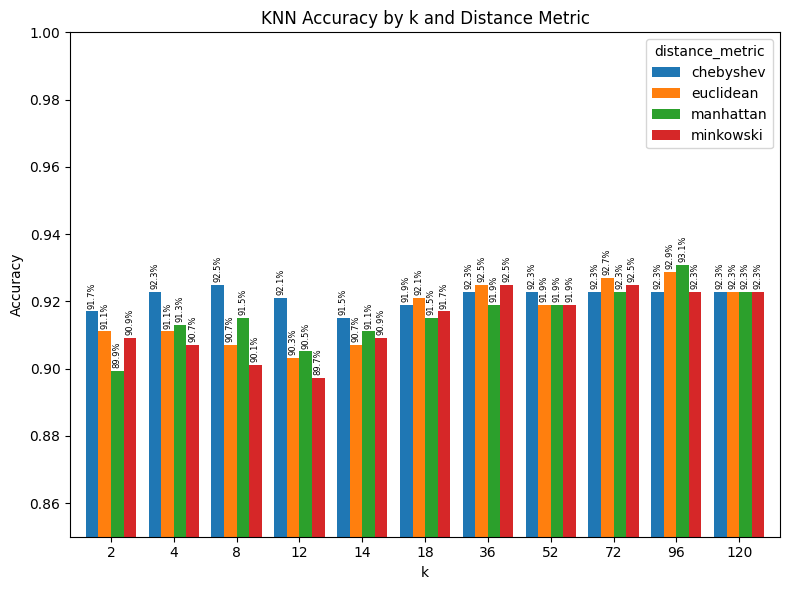

In [133]:
import matplotlib.pyplot as plt

# ensure k is numeric and sorted
collect_results['k'] = collect_results['k'].astype(int)
pivot = collect_results.pivot(index='k', columns='distance_metric', values='accuracy').sort_index()

# plot grouped bar chart
ax = pivot.plot(kind='bar', figsize=(8,6), width=0.8)
ax.set_xlabel('k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.85, 1)
ax.set_title('KNN Accuracy by k and Distance Metric')
ax.legend(title='distance_metric', loc='upper right')

# annotate bars with percentages
for p in ax.patches:
    h = p.get_height()
    if not np.isnan(h):
        x = p.get_x() + p.get_width() / 2
        y = h
        ax.annotate(f'{h*100:.1f}%', xy=(x, y), xytext=(0, 2),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=6, rotation=90)

plt.tight_layout()
plt.savefig(nn_run_dir + "knn_accuracy_comparison.png", dpi=300)
plt.show()

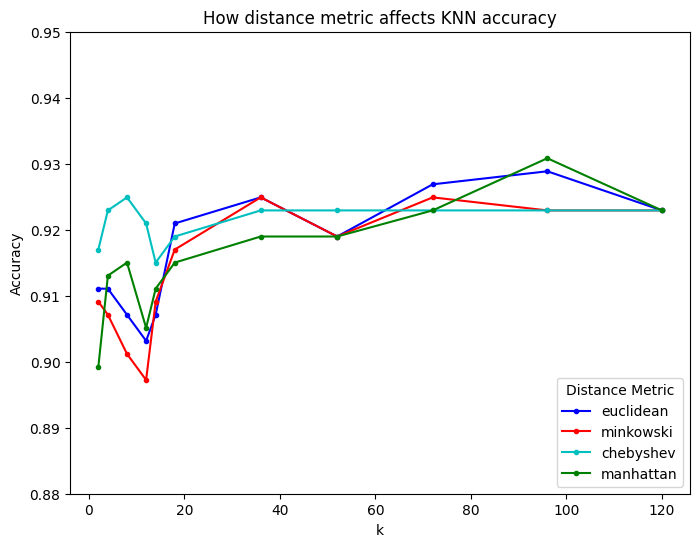

In [134]:
fig = plt.figure(figsize=(8,6))
# color dictionary for distance metrics
color_dict = {
    'euclidean': 'b',
    'manhattan': 'g',
    'minkowski': 'r',
    'chebyshev': 'c'
}
# plot lines for each distance metric
for dist in collect_results['distance_metric'].unique():
    subset = collect_results[collect_results['distance_metric'] == dist]
    plt.plot(subset['k'], subset['accuracy'], marker='.', label=dist, color=color_dict[dist])

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('How distance metric affects KNN accuracy')
plt.ylim(0.88, 0.95)
plt.legend(title='Distance Metric', loc='lower right')
plt.savefig(nn_run_dir + "knn_accuracy_distance_metric_comparison.png", dpi=300)
plt.show()